Name: Zhuoyuan Xu (Kallen)

NetID: zx1137

**Problem 1-3**

In [ ]:
"""Computation graph node types

Nodes must implement the following methods:
__init__   - initialize node
forward    - (step 1 of backprop) retrieve output ("out") of predecessor nodes (if
             applicable), update own output ("out"), and set gradient ("d_out") to zero
backward   - (step 2 of backprop), assumes that forward pass has run before.
             Also assumes that backward has been called on all of the node's
             successor nodes, so that self.d_out contains the
             gradient of the graph output with respect to the node output.
             Backward computes summands of the derivative of graph output with
             respect to the inputs of the node, corresponding to paths through the graph
             that go from the node's input through the node to the graph's output.
             These summands are added to the input node's d_out array.
get_predecessors - return a list of the node's parents

Nodes must furthermore have a the following attributes:
node_name  - node's name (a string)
out      - node's output
d_out    - derivative of graph output w.r.t. node output

This computation graph framework was designed and implemented by
Philipp Meerkamp, Pierre Garapon, and David Rosenberg.
License: Creative Commons Attribution 4.0 International License
"""

import numpy as np


class ValueNode(object):
    """Computation graph node having no input but simply holding a value"""
    def __init__(self, node_name):
        self.node_name = node_name
        self.out = None
        self.d_out = None

    def forward(self):
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        pass

    def get_predecessors(self):
        return []


class VectorScalarAffineNode(object):
    """ Node computing an affine function mapping a vector to a scalar."""
    def __init__(self, x, w, b, node_name):
        """ 
        Parameters:
        x: node for which x.out is a 1D numpy array
        w: node for which w.out is a 1D numpy array of same size as x.out
        b: node for which b.out is a numpy scalar (i.e. 0dim array)
        node_name: node's name (a string)
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.x = x
        self.w = w
        self.b = b

    def forward(self):
        self.out = np.dot(self.x.out, self.w.out) + self.b.out
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        d_x = self.d_out * self.w.out
        d_w = self.d_out * self.x.out
        d_b = self.d_out
        self.x.d_out += d_x
        self.w.d_out += d_w
        self.b.d_out += d_b

    def get_predecessors(self):
        return [self.x, self.w, self.b]


class SquaredL2DistanceNode(object):
    """ Node computing L2 distance (sum of square differences) between 2 arrays."""
    def __init__(self, a, b, node_name):
        """ 
        Parameters:
        a: node for which a.out is a numpy array
        b: node for which b.out is a numpy array of same shape as a.out
        node_name: node's name (a string)
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.a = a
        self.b = b
        # Variable for caching values between forward and backward
        self.a_minus_b = None

    def forward(self):
        self.a_minus_b = self.a.out - self.b.out
        self.out = np.sum(self.a_minus_b ** 2)
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        d_a = self.d_out * 2 * self.a_minus_b
        d_b = -self.d_out * 2 * self.a_minus_b
        self.a.d_out += d_a
        self.b.d_out += d_b
        return self.d_out

    def get_predecessors(self):
        return [self.a, self.b]


class L2NormPenaltyNode(object):
    """ Node computing l2_reg * ||w||^2 for scalars l2_reg and vector w"""
    def __init__(self, l2_reg, w, node_name):
        """ 
        Parameters:
        l2_reg: a numpy scalar array (e.g. np.array(.01)) (not a node)
        w: a node for which w.out is a numpy vector
        node_name: node's name (a string)
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.l2_reg = np.array(l2_reg)
        self.w = w

    def forward(self):
        self.out = self.l2_reg * np.linalg.norm(self.w.out) ** 2
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        d_w = self.d_out * (2 * self.l2_reg * self.w.out)
        self.w.d_out += d_w
        return self.d_out

    def get_predecessors(self):
        return [self.w]


class SumNode(object):
    """ Node computing a + b, for numpy arrays a and b"""
    def __init__(self, a, b, node_name):
        """ 
        Parameters:
        a: node for which a.out is a numpy array
        b: node for which b.out is a numpy array of the same shape as a
        node_name: node's name (a string)
        """
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.b = b
        self.a = a

    def forward(self):
        self.out = self.a.out + self.b.out
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        d_a = self.d_out
        d_b = self.d_out
        self.a.d_out += d_a
        self.b.d_out += d_b

    def get_predecessors(self):
        return [self.a, self.b]

In [ ]:
import setup_problem
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import nodes_zx1137 as nodes
import graph
import plot_utils

class RidgeRegression(BaseEstimator, RegressorMixin):
    """ Ridge regression with computation graph """
    def __init__(self, l2_reg=1, step_size=.005,  max_num_epochs = 5000):
        self.max_num_epochs = max_num_epochs
        self.step_size = step_size

        # Build computation graph
        self.x = nodes.ValueNode(node_name="x") # to hold a vector input
        self.y = nodes.ValueNode(node_name="y") # to hold a scalar response
        self.w = nodes.ValueNode(node_name="w") # to hold the parameter vector
        self.b = nodes.ValueNode(node_name="b") # to hold the bias parameter (scalar)
        self.prediction = nodes.VectorScalarAffineNode(x=self.x, w=self.w, b=self.b,
                                                 node_name="prediction")
        # Build computation graph
        self.reg_w = nodes.L2NormPenaltyNode(l2_reg=l2_reg, w=self.w, node_name="reg_w")
        self.obj = nodes.SquaredL2DistanceNode(a=self.y, b=self.prediction, node_name="diff")
        self.reg_obj = nodes.SumNode(self.reg_w, self.obj, node_name="reg_obj")
        self.graph = graph.ComputationGraphFunction(inputs=[self.x], outcomes=[self.y], parameters=[self.w,self.b], prediction=self.prediction, objective=self.reg_obj)
        
    def fit(self, X, y):
        num_instances, num_ftrs = X.shape
        y = y.reshape(-1)

        init_parameter_values = {"w": np.zeros(num_ftrs), "b": np.array(0.0)}
        self.graph.set_parameters(init_parameter_values)

        for epoch in range(self.max_num_epochs):
            shuffle = np.random.permutation(num_instances)
            epoch_obj_tot = 0.0
            for j in shuffle:
                obj, grads = self.graph.get_gradients(input_values = {"x": X[j]},
                                                    outcome_values = {"y": y[j]})
                #print(obj)
                epoch_obj_tot += obj
                # Take step in negative gradient direction
                steps = {}
                for param_name in grads:
                    steps[param_name] = -self.step_size * grads[param_name]
                self.graph.increment_parameters(steps)

            if epoch % 50 == 0:
                train_loss = sum((y - self.predict(X,y)) **2)/num_instances
                print("Epoch ",epoch,": Ave objective=",epoch_obj_tot/num_instances," Ave training loss: ",train_loss)

    def predict(self, X, y=None):
        try:
            getattr(self, "graph")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        num_instances = X.shape[0]
        preds = np.zeros(num_instances)
        for j in range(num_instances):
            preds[j] = self.graph.get_prediction(input_values={"x":X[j]})

        return preds



def main():
    data_fname = "data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = setup_problem.load_problem(data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    X = featurize(x)

    l2reg = 1
    estimator = RidgeRegression(l2_reg=l2reg, step_size=0.00005, max_num_epochs=2000)
    estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name, "preds": estimator.predict(X) })


    l2reg = 0
    estimator = RidgeRegression(l2_reg=l2reg, step_size=0.0005, max_num_epochs=500)
    estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name, "preds": estimator.predict(X) })

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.

    pred_fns.append({"name": "Target Parameter Values (i.e. Bayes Optimal)", "coefs": coefs_true, "preds": target_fn(x)})

    plot_utils.plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")

if __name__ == '__main__':
    main()

In [1]:
%run ridge_regression.t.py

DEBUG: (Node l2 norm node) Max rel error for partial deriv w.r.t. w is 6.372644513104131e-08.
.DEBUG: (Node sum node) Max rel error for partial deriv w.r.t. a is 2.8755654572009253e-11.
DEBUG: (Node sum node) Max rel error for partial deriv w.r.t. b is 2.8755654572009253e-11.
.DEBUG: (Parameter w) Max rel error for partial deriv 1.0832498418250635e-09.
DEBUG: (Parameter b) Max rel error for partial deriv 6.458361260311016e-10.
.
----------------------------------------------------------------------
Ran 3 tests in 0.006s

OK


Epoch  0 : Ave objective= 1.6094806213101527  Ave training loss:  0.8236515849382391
Epoch  50 : Ave objective= 0.3279977959462063  Ave training loss:  0.2417651352044313
Epoch  100 : Ave objective= 0.31649599409323076  Ave training loss:  0.21184374879140772
Epoch  150 : Ave objective= 0.31452890784244747  Ave training loss:  0.2037184825639585
Epoch  200 : Ave objective= 0.3121485084212521  Ave training loss:  0.20034182956314953
Epoch  250 : Ave objective= 0.31280373603957234  Ave training loss:  0.19877625082307304
Epoch  300 : Ave objective= 0.31248714459392785  Ave training loss:  0.19818356809561696
Epoch  350 : Ave objective= 0.3115031569492875  Ave training loss:  0.19765508280926666
Epoch  400 : Ave objective= 0.31067210531127976  Ave training loss:  0.19910064024346144
Epoch  450 : Ave objective= 0.3110554833622063  Ave training loss:  0.19774998980617353
Epoch  500 : Ave objective= 0.3102123976915999  Ave training loss:  0.19767856145932328
Epoch  550 : Ave objective= 0.309

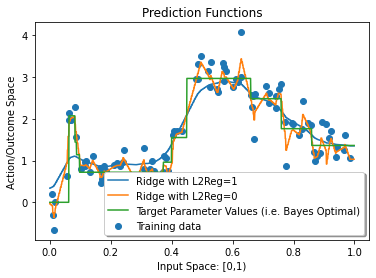

In [3]:
%run ridge_regression.py
logging.getLogger('matplotlib.font_manager').disabled = True

**Problem 4**

Given the definition $y=Wx+b$, we can write any entry $y_i$ in $y$ as $y_i=W_{ij}x_j+b_i$. In the derivative
$$\frac{\partial J}{\partial W_{ij}}=\sum^m_{r=1}\frac{\partial J}{\partial y_r}\frac{\partial y_r}{\partial W_{ij}}$$
we can see the part
$$\frac{\partial y_r}{\partial W_{ij}}=\begin{cases}
x_j & r=i\\
0 & \text{else}
\end{cases}$$ 

Therefore, the part of the derivative inside the summation $\frac{\partial J}{\partial y_r}\frac{\partial y_r}{\partial W_{ij}}$ has non-zero value only when $r=i$, i.e. $y_r=y_i$.
$$\frac{\partial J}{\partial W_{ij}}=\sum^m_{r=1}\frac{\partial J}{\partial y_r}\frac{\partial y_r}{\partial W_{ij}}=\frac{\partial J}{\partial y_i}x_j$$

**Problem 5**

Based on our result for problem 4, the vectorized expression for $\frac{\partial J}{\partial W}$ is $$\frac{\partial J}{\partial W}=\frac{\partial J}{\partial y}x^T$$where $\frac{\partial J}{\partial y}$ and $x$ are column vectors.

**Problem 6**

First, the elementwise expression for the derivative of $y$ with respect to $x$ can be written as $\frac{\partial y_r}{\partial x_i}=W_{ri}$. Then the expression for the i-th entry $\frac{\partial J}{\partial x_i}$ is 
$$\frac{\partial J}{\partial x_i}=\sum^m_{r=1}\frac{\partial J}{\partial y_r}\frac{\partial y_r}{\partial x_i}=\sum^m_{r=1}\frac{\partial J}{\partial y_r}W_{ri}=(\frac{\partial J}{\partial y})^TW_{:,i}$$
where $W_{:,i}$ denotes the i-th column in the matrix $W$.

From the above expression, we can show that for the entire vector $x$, $$\frac{\partial J}{\partial x}=W^T(\frac{\partial J}{\partial y})$$

**Problem 7**

The i-th entry in $b$ can be written as $$\frac{\partial J}{\partial b_i}=\sum^m_{r=1}\frac{\partial J}{\partial y_r}\frac{\partial y_r}{\partial b_i}$$
In this expression, $\frac{\partial y_r}{\partial b_i}=\begin{cases}
1 & r=i\\
0 & \text{else}
\end{cases}$, i.e. $\frac{\partial y_r}{\partial b_i}=\delta_{ri}$.

Thus the expression can be written as $$\frac{\partial J}{\partial b_i}=\sum^m_{r=1}\frac{\partial J}{\partial y_r}\frac{\partial y_r}{\partial b_i}=\frac{\partial J}{\partial y_r}\delta_{ri}=\frac{\partial J}{\partial y_i}$$

**Problem 8**

Given the rule $(A\odot B)_i=A_iB_i$, for this problem, to show $\frac{\partial J}{\partial A}=\frac{\partial J}{\partial S}\odot\sigma'(A)$, we prove the dirivative of $J$ with respect to the i-th entry of $A$ satisfy our expression, i.e. $\frac{\partial J}{\partial A_i}=(\frac{\partial J}{\partial S}\odot\sigma'(A))_i=\frac{\partial J}{\partial S_i}\sigma'(A_i)$

Based on similar ideas from the previous problem, we can write
$$\frac{\partial J}{\partial A_i}=\sum_{j}\frac{\partial J}{\partial S_j}\frac{\partial S_j}{\partial A_i}=\sum_{j}\frac{\partial J}{\partial S_j}\delta_{ij}\sigma'(A_i)=\frac{\partial J}{\partial S_i}\sigma'(A_i)$$

Therefore, $\frac{\partial J}{\partial A}=\frac{\partial J}{\partial S}\odot\sigma'(A)$

**Problem 9-11**

In [ ]:
class AffineNode(object):
    """Node implementing affine transformation (W,x,b)-->Wx+b, where W is a matrix,
    and x and b are vectors
        Parameters:
        W: node for which W.out is a numpy array of shape (m,d)
        x: node for which x.out is a numpy array of shape (d)
        b: node for which b.out is a numpy array of shape (m) (i.e. vector of length m)
    """
    def __init__(self, W, x, b, node_name):
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.W = W
        self.x = x
        self.b = b
    
    def forward(self):
        self.out = np.dot(self.W.out, self.x.out) + self.b.out
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        d_W = np.outer(self.d_out, self.x.out)
        d_x = np.dot(self.W.out.T, self.d_out)
        d_b = self.d_out
        self.W.d_out += d_W
        self.x.d_out += d_x
        self.b.d_out += d_b

    def get_predecessors(self):
        return [self.W, self.x, self.b]


class TanhNode(object):
    """Node tanh(a), where tanh is applied elementwise to the array a
        Parameters:
        a: node for which a.out is a numpy array
    """
    def __init__(self, a, node_name):
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.a = a
    
    def forward(self):
        self.out = np.tanh(self.a.out)
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        d_a = self.d_out * (1 - self.out ** 2)
        self.a.d_out += d_a

    def get_predecessors(self):
        return [self.a]

In [ ]:
import matplotlib.pyplot as plt
import setup_problem
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import nodes_zx1137 as nodes
import graph
import plot_utils
import pdb
#pdb.set_trace()


class MLPRegression(BaseEstimator, RegressorMixin):
    """ MLP regression with computation graph """
    def __init__(self, num_hidden_units=10, step_size=.005, init_param_scale=0.01, max_num_epochs = 5000):
        self.num_hidden_units = num_hidden_units
        self.init_param_scale = init_param_scale
        self.max_num_epochs = max_num_epochs
        self.step_size = step_size

        # Build computation graph
        # data
        self.x = nodes.ValueNode(node_name="x") # to hold a vector input
        self.y = nodes.ValueNode(node_name="y") # to hold a scalar response
        
        # parameters
        self.W1 = nodes.ValueNode(node_name="W1")
        self.b1 = nodes.ValueNode(node_name="b1")
        self.w2 = nodes.ValueNode(node_name="w2")
        self.b2 = nodes.ValueNode(node_name="b2")
        
        # hidden layer
        self.L = nodes.AffineNode(W=self.W1, x=self.x, b=self.b1, node_name="affine") 
        self.h = nodes.TanhNode(a=self.L, node_name="tanh")
        
        # prediction
        self.f = nodes.VectorScalarAffineNode(x=self.h, w=self.w2, b=self.b2, node_name="prediction")
        
        # objective
        self.J = nodes.SquaredL2DistanceNode(a=self.y, b=self.f, node_name="objective")
        
        self.graph = graph.ComputationGraphFunction(inputs=[self.x], outcomes=[self.y], parameters=[self.W1,self.b1,self.w2,self.b2], prediction=self.f, objective=self.J)

    def fit(self, X, y):
        num_instances, num_ftrs = X.shape
        y = y.reshape(-1)
        s = self.init_param_scale
        init_values = {"W1": s * np.random.standard_normal((self.num_hidden_units, num_ftrs)),
                       "b1": s * np.random.standard_normal((self.num_hidden_units)),
                       "w2": s * np.random.standard_normal((self.num_hidden_units)),
                       "b2": s * np.array(np.random.randn()) }

        self.graph.set_parameters(init_values)

        for epoch in range(self.max_num_epochs):
            shuffle = np.random.permutation(num_instances)
            epoch_obj_tot = 0.0
            for j in shuffle:
                obj, grads = self.graph.get_gradients(input_values = {"x": X[j]},
                                                    outcome_values = {"y": y[j]})
                #print(obj)
                epoch_obj_tot += obj
                # Take step in negative gradient direction
                steps = {}
                for param_name in grads:
                    steps[param_name] = -self.step_size * grads[param_name]
                self.graph.increment_parameters(steps)
                #pdb.set_trace()

            if epoch % 50 == 0:
                train_loss = sum((y - self.predict(X,y)) **2)/num_instances
                print("Epoch ",epoch,": Ave objective=",epoch_obj_tot/num_instances," Ave training loss: ",train_loss)

    def predict(self, X, y=None):
        try:
            getattr(self, "graph")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        num_instances = X.shape[0]
        preds = np.zeros(num_instances)
        for j in range(num_instances):
            preds[j] = self.graph.get_prediction(input_values={"x":X[j]})

        return preds



def main():
    data_fname = "data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = setup_problem.load_problem(data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

    pred_fns.append({"name": "Target Parameter Values (i.e. Bayes Optimal)", "coefs": coefs_true, "preds": target_fn(x)})

    estimator = MLPRegression(num_hidden_units=10, step_size=0.001, init_param_scale=.0005,  max_num_epochs=5000)
    x_train_as_column_vector = x_train.reshape(x_train.shape[0],1) # fit expects a 2-dim array
    x_as_column_vector = x.reshape(x.shape[0],1) # fit expects a 2-dim array
    estimator.fit(x_train_as_column_vector, y_train)
    name = "MLP regression - no features"
    pred_fns.append({"name":name, "preds": estimator.predict(x_as_column_vector) })
    #plot_utils.plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
    if (1==1):
        X = featurize(x)
        estimator = MLPRegression(num_hidden_units=10, step_size=0.0005, init_param_scale=.01,  max_num_epochs=500)
        estimator.fit(X_train, y_train)
        name = "MLP regression - with features"
        pred_fns.append({"name":name, "preds": estimator.predict(X) })
        plot_utils.plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")

if __name__ == '__main__':
    main()

In [1]:
%run mlp_regression.t.py

DEBUG: (Node affine) Max rel error for partial deriv w.r.t. W is 2.6727224425812336e-09.
DEBUG: (Node affine) Max rel error for partial deriv w.r.t. x is 1.2462746693581928e-09.
DEBUG: (Node affine) Max rel error for partial deriv w.r.t. b is 1.6365789325759677e-09.
.DEBUG: (Node tanh) Max rel error for partial deriv w.r.t. a is 6.926211828825294e-09.
.DEBUG: (Parameter W1) Max rel error for partial deriv 7.757046786710294e-06.
DEBUG: (Parameter b1) Max rel error for partial deriv 6.48927428756324e-07.
DEBUG: (Parameter w2) Max rel error for partial deriv 1.7955448355231087e-09.
DEBUG: (Parameter b2) Max rel error for partial deriv 5.873348475102835e-10.
.
----------------------------------------------------------------------
Ran 3 tests in 0.010s

OK


Epoch  0 : Ave objective= 3.137516391575231  Ave training loss:  2.7222678638542765
Epoch  50 : Ave objective= 0.9453888583974991  Ave training loss:  0.9435144534800395
Epoch  100 : Ave objective= 0.9450755362110279  Ave training loss:  0.9432050024618686
Epoch  150 : Ave objective= 0.9419951828013727  Ave training loss:  0.9400330084192745
Epoch  200 : Ave objective= 0.9155739653251257  Ave training loss:  0.9128468688299803
Epoch  250 : Ave objective= 0.8241666838576367  Ave training loss:  0.8200423909145509
Epoch  300 : Ave objective= 0.7736395414396828  Ave training loss:  0.769560110586592
Epoch  350 : Ave objective= 0.7669902623365532  Ave training loss:  0.7626854449456703
Epoch  400 : Ave objective= 0.762091631250786  Ave training loss:  0.7578812526409072
Epoch  450 : Ave objective= 0.7559249967010055  Ave training loss:  0.7518482998376459
Epoch  500 : Ave objective= 0.7483226554000626  Ave training loss:  0.7446265725733725
Epoch  550 : Ave objective= 0.7405672136626323  A

Epoch  4650 : Ave objective= 0.24974842190562996  Ave training loss:  0.2451883736863967
Epoch  4700 : Ave objective= 0.24936992700031674  Ave training loss:  0.24448763831093995
Epoch  4750 : Ave objective= 0.24903905248332667  Ave training loss:  0.24391478582267084
Epoch  4800 : Ave objective= 0.24823475752764243  Ave training loss:  0.2432244407535074
Epoch  4850 : Ave objective= 0.24693002138529907  Ave training loss:  0.2425504303178255
Epoch  4900 : Ave objective= 0.24657090884684896  Ave training loss:  0.24212550482009576
Epoch  4950 : Ave objective= 0.2465022711516545  Ave training loss:  0.24135035321254816
Epoch  0 : Ave objective= 3.206540758880964  Ave training loss:  2.7600393335666866
Epoch  50 : Ave objective= 0.15007484988457595  Ave training loss:  0.14527634097721806
Epoch  100 : Ave objective= 0.11680875705102287  Ave training loss:  0.10942355055645007
Epoch  150 : Ave objective= 0.10051792450477723  Ave training loss:  0.08974775819159062
Epoch  200 : Ave objecti

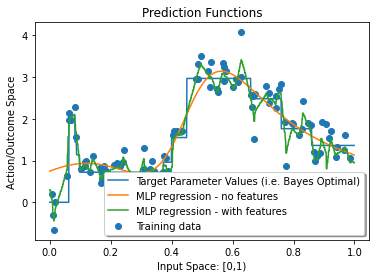

NameError: name 'logging' is not defined

In [4]:
%run mlp_regression.py
logging.getLogger('matplotlib.font_manager').disabled = True

**Problem 12-14** 

In [ ]:
class SoftmaxNode(object):
    """ Softmax node
        Parameters:
        z: node for which z.out is a numpy array
    """
    def __init__(self, z, node_name):
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.z = z
    
    def forward(self):
        total_prob = np.sum([np.exp(self.z.out[k]) for k in range(len(self.z.out))])
        self.out = np.array([np.exp(self.z.out[k])/total_prob for k in range(len(self.z.out))])
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        derivative = np.empty([len(self.z.out), len(self.out)])
        for i in range(len(self.z.out)):
            for j in range(len(self.out)):
                if i == j:
                    derivative[i][j] = self.out[i] * (1-self.out[i])
                else:
                    derivative[i][j] = -self.out[i] * self.out[j]
                
        d_z = np.dot(self.d_out, derivative)
        self.z.d_out += d_z

    def get_predecessors(self):
        return [self.z]


class NLLNode(object):
    """ Node computing NLL loss between 2 arrays.
        Parameters:
        y_hat: a node that contains all predictions
        y_true: a node that contains all labels
    """
    def __init__(self, y_hat, y_true, node_name):
        self.node_name = node_name
        self.out = None
        self.d_out = None
        self.y_hat = y_hat
        self.y_true = y_true
    
    def forward(self):
        self.out = -np.log(self.y_hat.out[self.y_true.out])
        self.d_out = np.zeros(self.out.shape)
        return self.out

    def backward(self):
        d_ytrue = self.d_out * (-self.y_hat.out[self.y_true.out]/np.exp(-self.out))
        d_yhat = np.zeros(self.y_hat.out.shape)
        d_yhat[self.y_true.out] = 1
        d_yhat = self.d_out * (-d_yhat/np.exp(-self.out))
        self.y_hat.d_out += d_yhat
        self.y_true.d_out += d_ytrue

    def get_predecessors(self):
        return [self.y_hat, self.y_true]

In [ ]:
import setup_problem
from sklearn.base import BaseEstimator, RegressorMixin
try:
    from sklearn.datasets.samples_generator import make_blobs
except:
    from sklearn.datasets import make_blobs
import numpy as np
import nodes_zx1137 as nodes
import graph

def calculate_nll(y_preds, y):
    """
    Function that calculate the average NLL loss
    :param y_preds: N * C probability array
    :param y: N int array
    :return:
    """
    return np.mean(-np.log(y_preds)[np.arange(len(y)),y])


class MulticlassClassifier(BaseEstimator, RegressorMixin):
    """ Multiclass prediction """
    def __init__(self, num_hidden_units=10, step_size=.005, init_param_scale=0.01, max_num_epochs = 1000, num_class=3):
        self.num_hidden_units = num_hidden_units
        self.init_param_scale = init_param_scale
        self.max_num_epochs = max_num_epochs
        self.step_size = step_size
        self.num_class = num_class

        # Build computation graph
        # data
        self.x = nodes.ValueNode(node_name="x") # to hold a vector input
        self.y = nodes.ValueNode(node_name="y") # to hold a scalar response
        
        # parameters
        self.W1 = nodes.ValueNode(node_name="W1")
        self.b1 = nodes.ValueNode(node_name="b1")
        self.W2 = nodes.ValueNode(node_name="W2")
        self.b2 = nodes.ValueNode(node_name="b2")
        
        # hidden layer
        self.L = nodes.AffineNode(W=self.W1, x=self.x, b=self.b1, node_name="affineW1b1") 
        self.h = nodes.TanhNode(a=self.L, node_name="tanh")
        self.z = nodes.AffineNode(W=self.W2, x=self.h, b=self.b2, node_name="affineb2w2")
        
        # prediction
        self.f = nodes.SoftmaxNode(z=self.z, node_name="softmax")
        
        # objective
        self.J = nodes.NLLNode(y_hat=self.f, y_true=self.y, node_name='objective')
        
        self.graph = graph.ComputationGraphFunction(inputs=[self.x], outcomes=[self.y], parameters=[self.W1,self.b1,self.W2,self.b2], prediction=self.f, objective=self.J)

    def fit(self, X, y):
        num_instances, num_ftrs = X.shape
        y = y.reshape(-1)
        s = self.init_param_scale
        init_values = {"W1": s * np.random.standard_normal((self.num_hidden_units, num_ftrs)),
                       "b1": s * np.random.standard_normal((self.num_hidden_units)),
                       "W2": np.random.standard_normal((self.num_class, self.num_hidden_units)),
                       "b2": np.array(np.random.randn(self.num_class)) }
        self.graph.set_parameters(init_values)

        for epoch in range(self.max_num_epochs):
            shuffle = np.random.permutation(num_instances)
            epoch_obj_tot = 0.0
            for j in shuffle:
                obj, grads = self.graph.get_gradients(input_values = {"x": X[j]},
                                                    outcome_values = {"y": y[j]})
                #print(obj)
                epoch_obj_tot += obj
                # Take step in negative gradient direction
                steps = {}
                for param_name in grads:
                    steps[param_name] = -self.step_size * grads[param_name]
                self.graph.increment_parameters(steps)
                #pdb.set_trace()

            if epoch % 50 == 0:
                train_loss = calculate_nll(self.predict(X,y), y)
                print("Epoch ",epoch," Ave training loss: ",train_loss)

    def predict(self, X, y=None):
        try:
            getattr(self, "graph")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        num_instances = X.shape[0]
        preds = []
        for j in range(num_instances):
            preds.append(self.graph.get_prediction(input_values={"x":X[j]}).reshape(1,-1))

        return np.concatenate(preds, axis=0)



def main():
    # load the data from HW5
    np.random.seed(2)
    X, y = make_blobs(n_samples=500, cluster_std=.25, centers=np.array([(-3, 1), (0, 2), (3, 1)]))
    training_X = X[:300]
    training_y = y[:300]
    test_X = X[300:]
    test_y = y[300:]

    # train the model
    estimator = MulticlassClassifier()
    estimator.fit(training_X, training_y)

    # report test accuracy
    test_acc = np.sum(np.argmax(estimator.predict(test_X), axis=1)==test_y)/len(test_y)
    print("Test set accuracy = {:.3f}".format(test_acc))


if __name__ == '__main__':
    main()

In [1]:
%run multiclass.t.py

C:\Users\kalle\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
DEBUG: (Node softmax) Max rel error for partial deriv w.r.t. z is 1.5385742524215873e-09.
.DEBUG: (Parameter W1) Max rel error for partial deriv 2.1791491311701626e-07.
DEBUG: (Parameter b1) Max rel error for partial deriv 5.4507464417531275e-08.
DEBUG: (Parameter W2) Max rel error for partial deriv 6.754800815066246e-08.
DEBUG: (Parameter b2) Max rel error for partial deriv 2.205053947010376e-08.
.
----------------------------------------------------------------------
Ran 2 tests in 0.012s

OK


In [2]:
%run multiclass.py

Epoch  0  Ave training loss:  0.10767753468425852
Epoch  50  Ave training loss:  0.0037402729498018897
Epoch  100  Ave training loss:  0.0019509875089186069
Epoch  150  Ave training loss:  0.00131892201003299
Epoch  200  Ave training loss:  0.0009947600104512856
Epoch  250  Ave training loss:  0.0007975221227263997
Epoch  300  Ave training loss:  0.0006649220947379011
Epoch  350  Ave training loss:  0.0005697138957458585
Epoch  400  Ave training loss:  0.0004980771960410216
Epoch  450  Ave training loss:  0.00044225221211177576
Epoch  500  Ave training loss:  0.0003975450315101259
Epoch  550  Ave training loss:  0.0003609495175393885
Epoch  600  Ave training loss:  0.0003304520224436157
Epoch  650  Ave training loss:  0.0003046529432352649
Epoch  700  Ave training loss:  0.0002825495526238341
Epoch  750  Ave training loss:  0.0002634047943162139
Epoch  800  Ave training loss:  0.00024666486030361454
Epoch  850  Ave training loss:  0.0002319056839595022
Epoch  900  Ave training loss:  0